# Basic GTM Training for S-curve

## Importing libraries

In [1]:
import os
import numpy as np
import torch
from sklearn.datasets import make_s_curve

# GTM and utils
from gtmkit.gtm import GTM
from gtmkit.utils.molecules import calculate_latent_coords
from gtmkit.utils.regression import get_reg_density_matrix, reg_density_to_table

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  # needed for 3D subplot
import altair as alt
from gtmkit.plots.altair_landscapes import (
    altair_points_chart,
    altair_discrete_regression_landscape,
)


/home/aorlov/.local/share/pdm/venvs/GTMKit-Qd2JC5GH-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating an S-curve dataset

In [2]:
# -----------------------
# 1) Data: S-curve in 3D + extra noise dim
# -----------------------
rng = np.random.RandomState(0)
n_samples = 5000

# S-curve: (n_samples, 3) and per-sample "color" parameter along the curve
s_curve_3d, s_curve_color = make_s_curve(n_samples, random_state=rng)

# Add extra random feature to make it higher dimensional
extra_dims = rng.randn(n_samples, 1)
X = np.hstack([s_curve_3d, extra_dims])

# Torch tensor (double precision often helps EM stability)
device = "cuda" if torch.cuda.is_available() else "cpu"
X_t = torch.tensor(X, dtype=torch.float64, device=device)

## Building the GTM

In [3]:
# -----------------------
# 2) Fit GTM
# -----------------------
gtm = GTM(
    num_nodes=225,             # 15 x 15 grid
    num_basis_functions=100,   # 10 x 10 RBF centers
    basis_width=1.0,
    reg_coeff=1.0,
    device=device,
    standardize=False,         # set True if your real data needs z-scoring
    pca_scale=True,
    pca_engine="torch",
    max_iter=200,
)
gtm.fit(X_t)

 29%|██████▍               | 58/200 [00:01<00:04, 34.67it/s, LLh=-4, deltaLLh=0.00096, beta=23]


## Plotting the results with matplotlib

Latent coordinates shape: (5000, 2)


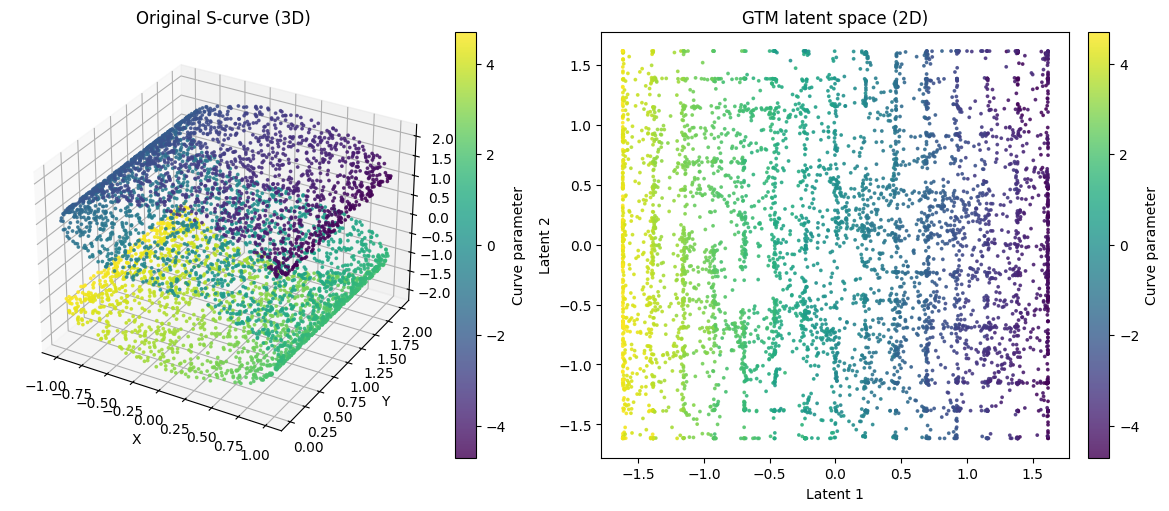

In [4]:
Z = gtm.transform(X_t)  # [n_samples, 2]
print(f"Latent coordinates shape: {tuple(Z.shape)}")

# -----------------------
# 3) Immediate visualization (matplotlib)
# 1x2 subplots: original 3D vs latent 2D
# -----------------------
Z_np = Z.detach().to("cpu").numpy() if hasattr(Z, "detach") else np.asarray(Z)
X3d_np = np.asarray(s_curve_3d)
color = np.asarray(s_curve_color)

fig = plt.figure(figsize=(12, 5), constrained_layout=True)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
p1 = ax1.scatter(
    X3d_np[:, 0], X3d_np[:, 1], X3d_np[:, 2],
    c=color, cmap='viridis', s=3, alpha=0.8
)
ax1.set_title('Original S-curve (3D)')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
fig.colorbar(p1, ax=ax1, fraction=0.046, pad=0.04, label='Curve parameter')

ax2 = fig.add_subplot(1, 2, 2)
p2 = ax2.scatter(
    Z_np[:, 0], Z_np[:, 1],
    c=color, cmap='viridis', s=3, alpha=0.8
)
ax2.set_title('GTM latent space (2D)')
ax2.set_xlabel('Latent 1'); ax2.set_ylabel('Latent 2')
fig.colorbar(p2, ax=ax2, fraction=0.046, pad=0.04, label='Curve parameter')

plt.show()

## Interactive plotting with Altair: scatter plot and regression density landscape

In [5]:
# -----------------------
# 4) Responsibilities for landscapes
# -----------------------
responsibilities, log_likelihoods = gtm.project(X_t)

# Convert responsibilities to NumPy on CPU and fix orientation to (n_samples, n_nodes)
R = responsibilities
if hasattr(R, "detach"):
    R = R.detach()
R_np = R.to("cpu").numpy()
if R_np.shape[0] != n_samples:
    R_np = R_np.T

n_nodes = R_np.shape[1]
grid_size = int(np.sqrt(n_nodes))
assert grid_size * grid_size == n_nodes, "num_nodes must be a perfect square."

# -----------------------
# 5) Regression landscape (no density chart)
#    Left: latent points (Altair)
#    Right: regression landscape (Altair)
# -----------------------
# Use the intrinsic curve parameter as the regression target
regression_values = s_curve_color

# Node densities and per-node regression values
density, reg_density = get_reg_density_matrix(R_np, regression_values)

# Tidy table for the regression landscape
reg_table = reg_density_to_table(
    density,
    reg_density,
    node_threshold=0.10  # ignore very sparse nodes for cleaner viz
)

coords = calculate_latent_coords(
    R_np,
    correction=True,
    return_node=True
)
coords["color"] = regression_values



### Points chart

In [6]:
# Latent coordinates for samples (for the points panel)

# Points (left) — use same viridis scheme for consistency with matplotlib
points_chart = altair_points_chart(
    coords.sample(min(5000, len(coords)), random_state=0),
    num_nodes=grid_size,
    points_size=120,
    coloring_scheme='viridis',
    coloring_column='color',
    legend=None
)


### Regression landscape

In [7]:
# Regression landscape (right)
reg_chart = altair_discrete_regression_landscape(
    reg_table,
    title="GTM Regression Landscape",
    colorset='viridis')



### Combining landscapes and saving them

In [9]:
# --- make the two panels the same size and aligned ---
SIZE = 100  # pick any; same for both

points_aligned = (
    points_chart                     # from altair_points_chart(...)
    .properties(width=SIZE, height=SIZE, title='')
)

reg_aligned = (
    reg_chart                        # from altair_discrete_regression_landscape(...)
    .properties(width=SIZE*5, height=SIZE*5, title='')
)

combined = (
    alt.hconcat(points_aligned, reg_aligned)
      .resolve_scale(color='independent')     # avoid cross-panel legend/scale coupling
      .configure_concat(spacing=12)
      .configure_view(stroke=None)            # optional: remove outer border
)

combined = alt.hconcat(points_aligned, reg_aligned).properties(
    title="Latent points (colored by target) — GTM Regression Landscape"
)


# Try displaying inline; always save to HTML as well
out_dir = "plots"
os.makedirs(out_dir, exist_ok=True)
html_path = os.path.join(out_dir, "gtm_scurve_regression.html")
combined.save(html_path)
print(f"Saved Altair visualization to {html_path}")

# Optionally display in notebooks that support Altair rendering:
combined


Saved Altair visualization to plots/gtm_scurve_regression.html


alt.HConcatChart(...)